## VR Mini Project - Face Mask Detection
 
 This notebook implements solutions for the first two tasks from the assignment: 
 - **Binary Classification Using Handcrafted Features and ML Classifiers**
 - **Binary Classification Using CNN**

 The goal is to classify images of people wearing face masks and those without masks.

## Importing Required Libraries  

We import essential libraries for image processing, machine learning, and deep learning.  
- **OpenCV** for image loading and preprocessing  
- **Scikit-image** for feature extraction  
- **Scikit-learn** for ML classifiers  
- **TensorFlow/Keras** for deep learning (CNN)  
- **Matplotlib** for visualization  


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from skimage.feature import local_binary_pattern
# Import TensorFlow & Keras for CNN implementation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Load Images from Directory  

This function loads images from a given directory and assigns labels.  
- **Input**: Folder path and label (1 for "with mask", 0 for "without mask")  
- **Output**: A list of images and their corresponding labels  

In [3]:
# Function to load images from directory
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, filename)
            try:
                # Read image and convert to grayscale for feature extraction
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return images, labels

## Feature Extraction and Combining them
- Extract Histogram of Oriented Gradients (HOG) features for each image.
def extract_hog_features(images, image_size=(64, 64)).
- Extract color histogram features from the images to help with classification
- Combine HOG and color histogram features into a single feature vector.

In [4]:
def extract_hog_features(images, image_size=(64, 64)):
    hog_features = []
    for img in images:
        # Resize for consistency
        resized = cv2.resize(img, image_size)
        # Convert to grayscale
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        # Extract HOG features
        features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Function to extract color histogram features
def extract_color_histogram(images, image_size=(64, 64)):
    color_features = []
    for img in images:
        resized = cv2.resize(img, image_size)
        # Convert to HSV color space (more robust for color analysis)
        hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
        # Calculate histogram for each channel and concatenate
        hist_h = cv2.calcHist([hsv], [0], None, [32], [0, 180])
        hist_s = cv2.calcHist([hsv], [1], None, [32], [0, 256])
        hist_v = cv2.calcHist([hsv], [2], None, [32], [0, 256])
        # Flatten and normalize
        hist_features = np.concatenate([hist_h.flatten(), hist_s.flatten(), hist_v.flatten()])
        hist_features = hist_features / np.sum(hist_features)  # Normalize
        color_features.append(hist_features)
    return np.array(color_features)

# Function to combine multiple features
def combine_features(hog_features, color_features):
    return np.hstack((hog_features, color_features))

## Preparing Data for Machine Learning Models  

Loads images, extracts features, and prepares data for ML classification.  
- **Process**:  
  - Load "with mask" and "without mask" images  
  - Extract HOG and color histogram features  
  - Combine features  
  - Split dataset into training and testing sets  
  - Apply feature scaling (Standardization)  
- **Output**: `X_train, X_test, y_train, y_test`  


In [5]:
def prepare_data_ml(with_mask_dir, without_mask_dir):
    # Load mask images (class 1)
    print("Loading mask images...")
    mask_images, mask_labels = load_images_from_folder(with_mask_dir, 1)
    # Load non-mask images (class 0)
    print("Loading non-mask images...")
    no_mask_images, no_mask_labels = load_images_from_folder(without_mask_dir, 0)
    
    # Combine data
    all_images = mask_images + no_mask_images
    all_labels = mask_labels + no_mask_labels
    
    # Extract features
    print("Extracting HOG features...")
    hog_features = extract_hog_features(all_images)
    
    print("Extracting color histogram features...")
    color_features = extract_color_histogram(all_images)
    
    # Combine features
    print("Combining features...")
    X = combine_features(hog_features, color_features)
    y = np.array(all_labels)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(f"Data prepared: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples")
    
    return X_train, X_test, y_train, y_test

##  Training and Evaluating ML Classifiers  

Trains and evaluates two machine learning models:  
- **Support Vector Machine (SVM)** with RBF kernel  
- **Multi-layer Perceptron (MLP) Neural Network**  

**Metrics Used:**  
- Accuracy  
- Classification Report  
- Confusion Matrix  

In [6]:
def train_evaluate_ml_classifiers(X_train, X_test, y_train, y_test):
    # 1. Support Vector Machine (SVM)
    print("Training SVM classifier...")
    svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    print(f"SVM Accuracy: {svm_accuracy:.4f}")
    print("Classification Report for SVM:")
    print(classification_report(y_test, svm_pred, target_names=['Without Mask', 'With Mask']))
    
    # 2. Neural Network Classifier
    print("\nTraining Neural Network classifier...")
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', 
                        solver='adam', max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)
    mlp_pred = mlp.predict(X_test)
    mlp_accuracy = accuracy_score(y_test, mlp_pred)
    print(f"Neural Network Accuracy: {mlp_accuracy:.4f}")
    print("Classification Report for Neural Network:")
    print(classification_report(y_test, mlp_pred, target_names=['Without Mask', 'With Mask']))
    
    return svm, mlp, svm_pred, mlp_pred, svm_accuracy, mlp_accuracy

##  Visualizing ML Results  

To better understand the performance of our ML classifiers, we visualize:  
- **Confusion Matrices** for both SVM and MLP classifiers  
- **Accuracy Comparison Bar Chart** between the two models  


In [7]:
def visualize_ml_results(y_test, svm_pred, mlp_pred, svm_accuracy, mlp_accuracy):
    # Confusion Matrix for SVM
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, svm_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('SVM Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Without Mask', 'With Mask'], rotation=45)
    plt.yticks(tick_marks, ['Without Mask', 'With Mask'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    # Confusion Matrix for Neural Network
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, mlp_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Neural Network Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Without Mask', 'With Mask'], rotation=45)
    plt.yticks(tick_marks, ['Without Mask', 'With Mask'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.savefig('ml_confusion_matrices.png')
    plt.show()
    
    # Accuracy comparison bar chart
    plt.figure(figsize=(8, 6))
    classifiers = ['SVM', 'Neural Network']
    accuracies = [svm_accuracy, mlp_accuracy]
    plt.bar(classifiers, accuracies, color=['blue', 'orange'])
    plt.ylim(0.8, 1.0)  # Adjust as needed
    plt.title('ML Classifier Accuracy Comparison')
    plt.ylabel('Accuracy')
    
    # Add accuracy values on bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.4f}', horizontalalignment='center')
    
    plt.savefig('ml_accuracy_comparison.png')
    plt.show()
    
    # Return the best ML accuracy
    return max(svm_accuracy, mlp_accuracy)

##  Loading and Preprocessing Data for CNN  

Loads and preprocesses images for CNN training.  
- **Process**:  
  - Load images and resize them to `128x128`  
  - Convert to RGB and normalize pixel values  
  - Split into training and testing sets  
  - Convert labels to categorical (one-hot encoding)  
- **Output**: `X_train, X_test, y_train, y_test`  


In [8]:
def load_and_preprocess_data_cnn(with_mask_dir, without_mask_dir, img_size=(128, 128)):
    # Initialize lists to hold images and labels
    images = []
    labels = []
    
    # Load images with mask (class 1)
    print("Loading images with masks for CNN...")
    for filename in os.listdir(with_mask_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(with_mask_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    # Convert BGR to RGB (TensorFlow uses RGB)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Normalize pixel values to [0, 1]
                    img = img / 255.0
                    images.append(img)
                    labels.append(1)  # Class 1 for with_mask
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    # Load images without mask (class 0)
    print("Loading images without masks for CNN...")
    for filename in os.listdir(without_mask_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(without_mask_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0
                    images.append(img)
                    labels.append(0)  # Class 0 for without_mask
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fix validation batch size issue - adjust test set size to be a multiple of batch size
    batch_size = 32  # Common batch size
    test_samples = (X_test.shape[0] // batch_size) * batch_size
    if test_samples < X_test.shape[0]:
        X_test = X_test[:test_samples]
        y_test = y_test[:test_samples]
    
    # Convert labels to categorical (one-hot encoding)
    y_train_cat = to_categorical(y_train, num_classes=2)
    y_test_cat = to_categorical(y_test, num_classes=2)
    
    print(f"CNN Data prepared: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples")
    
    return X_train, X_test, y_train_cat, y_test_cat, y_train, y_test

## Creating the CNN Model  

A Convolutional Neural Network (CNN) architecture for binary classification.  
- **Architecture**:  
  - 3 convolutional blocks (Conv2D + BatchNorm + MaxPooling + Dropout)  
  - Flatten layer followed by fully connected Dense layers  
  - Softmax activation for binary classification  
- **Output**: A compiled CNN model  

In [9]:
def create_cnn_model(input_shape, activation='relu', dropout_rate=0.5):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation=activation, padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation=activation, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation=activation, padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation=activation, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation=activation, padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation=activation, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Fully connected layers
        Flatten(),
        Dense(256, activation=activation),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(2, activation='softmax')  # 2 classes: with mask and without mask
    ])
    
    return model

## Training CNN with Hyperparameters  

Trains the CNN with different hyperparameter configurations:  
- Learning Rate: `[0.001, 0.1, 0.005]`  
- Optimizers: `[Adam, RMSprop]`  
- Activation Functions: `[ReLU, ELU]`  
- Batch Sizes: `[16, 32]`  

**Training Enhancements:**  
- Data Augmentation (rotation, shift, zoom, flip)  
- Early Stopping & Learning Rate Reduction  


In [10]:
def train_with_hyperparameters(X_train, X_test, y_train, y_test, y_train_orig, y_test_orig):
    # Base hyperparameters
    input_shape = X_train.shape[1:]
    batch_size = 32
    epochs = 15
    
    # Define hyperparameter variations to try
    learning_rates = [0.001,0.1,0.005]
    optimizers = ['adam']
    activations = ['relu']
    batch_sizes = [16,32]
    
    # Store results for comparison
    results = []
    histories = []
    
    # Setup data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    
    # Setup callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    
    # Train models with different hyperparameter configurations
    config_num = 1
    total_configs = len(learning_rates) * len(optimizers) * len(activations) * len(batch_sizes)
    
    for lr in learning_rates:
        for opt_name in optimizers:
            for activation in activations:
                for bs in batch_sizes:
                    print(f"\nTraining configuration {config_num}/{total_configs}:")
                    print(f"Learning Rate: {lr}, Optimizer: {opt_name}, Activation: {activation}, Batch Size: {bs}")
                    
                    # Create model
                    model = create_cnn_model(input_shape, activation=activation)
                    
                    # Setup optimizer
                    if opt_name == 'adam':
                        optimizer = Adam(learning_rate=lr)
                    elif opt_name == 'rmsprop':
                        optimizer = RMSprop(learning_rate=lr)
                    else:
                        optimizer = SGD(learning_rate=lr)
                    
                    # Compile model
                    model.compile(optimizer=optimizer,
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])
                    
                    # Train model
                    history = model.fit(
                        datagen.flow(X_train, y_train, batch_size=bs),
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        callbacks=callbacks
                    )
                    
                    # Evaluate model
                    _, accuracy = model.evaluate(X_test, y_test,verbose=0)
                    y_pred = np.argmax(model.predict(X_test,verbose=0), axis=1)
                    
                    # Store results
                    config_result = {
                        'config_num': config_num,
                        'learning_rate': lr,
                        'optimizer': opt_name,
                        'activation': activation,
                        'batch_size': bs,
                        'accuracy': accuracy,
                        'model': model,
                        'y_pred': y_pred
                    }
                    results.append(config_result)
                    histories.append(history)
                    
                    config_num += 1
    
    return results, histories

##  Visualizing CNN Training History  

Plots the training accuracy and loss for the best CNN configuration.  
- **Accuracy vs. Epochs**  
- **Loss vs. Epochs**  

In [11]:
def plot_training_history(histories, results):
    best_idx = np.argmax([result['accuracy'] for result in results])
    best_history = histories[best_idx]
    best_config = results[best_idx]
    
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'], label='Train Accuracy')
    plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Best Model Accuracy (Config {best_config["config_num"]})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'], label='Train Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.title('Best Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('cnn_training_history.png')
    plt.show()
    
    return best_idx

# Visualize CNN results across configurations
def visualize_cnn_results(results, y_test_orig):
    # Create accuracy comparison
    config_nums = [result['config_num'] for result in results]
    accuracies = [result['accuracy'] for result in results]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(config_nums, accuracies, color='skyblue')
    plt.xlabel('Configuration Number')
    plt.ylabel('Accuracy')
    plt.title('CNN Accuracy Comparison Across Different Hyperparameters')
    plt.xticks(config_nums)
    plt.ylim(0.75, 1.0)  # Adjust as needed
    
    # Add accuracy values on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{accuracies[i]:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('cnn_accuracy_comparison.png')
    plt.show()
    
    # Get best model results
    best_idx = np.argmax(accuracies)
    best_config = results[best_idx]
    best_y_pred = best_config['y_pred']
    
    # Create confusion matrix for best model
    cm = confusion_matrix(y_test_orig, best_y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Best CNN Model (Config {best_config["config_num"]})')
    plt.colorbar()
    classes = ['Without Mask', 'With Mask']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig('cnn_confusion_matrix.png')
    plt.show()
    
    # Print best configuration details
    print("\nBest CNN Model Configuration:")
    print(f"Configuration {best_config['config_num']}:")
    print(f"Learning Rate: {best_config['learning_rate']}")
    print(f"Optimizer: {best_config['optimizer']}")
    print(f"Activation: {best_config['activation']}")
    print(f"Batch Size: {best_config['batch_size']}")
    print(f"Accuracy: {best_config['accuracy']:.4f}")
    
    # Classification report for best model
    print("\nClassification Report for Best CNN Model:")
    print(classification_report(y_test_orig, best_y_pred, target_names=classes))
    
    return best_config

## Comparing ML and CNN Performance  

Compares the accuracy of:  
- **SVM Classifier**  
- **MLP Neural Network**  
- **Convolutional Neural Network (CNN)**  

The comparison helps determine whether handcrafted features with ML classifiers  
or deep learning with CNN is better for face mask detection.  


In [12]:
def compare_all_methods(cnn_accuracy, ml_accuracies):
    # Create comparison chart
    plt.figure(figsize=(10, 6))
    methods = ['SVM', 'Neural Network', 'CNN']
    accuracies = [ml_accuracies['svm'], ml_accuracies['mlp'], cnn_accuracy]
    
    bars = plt.bar(methods, accuracies, color=['blue', 'orange', 'green'])
    plt.ylabel('Accuracy')
    plt.title('Comparison: ML Classifiers vs CNN')
    plt.ylim(0.8, 1.0)  # Adjust as needed
    
    # Add accuracy values on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{accuracies[i]:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('comparison_all_methods.png')
    plt.show()
    
    # Print comparison
    print("\nComparison of All Methods:")
    print(f"SVM Accuracy: {ml_accuracies['svm']:.4f}")
    print(f"Neural Network Accuracy: {ml_accuracies['mlp']:.4f}")
    print(f"CNN Accuracy: {cnn_accuracy:.4f}")
    
    # Determine best method
    best_method = methods[np.argmax(accuracies)]
    print(f"\nBest performing method: {best_method}")
    
    # Analysis
    print("\nAnalysis:")
    if cnn_accuracy > max(ml_accuracies['svm'], ml_accuracies['mlp']):
        print("The CNN outperforms traditional ML classifiers, which is expected since CNNs can automatically learn relevant features from image data.")
    else:
        print("Interestingly, the traditional ML classifiers perform competitively with or better than the CNN for this task.")



--- PART A: Binary Classification Using Handcrafted Features and ML Classifiers ---

Loading mask images...
Loading non-mask images...
Extracting HOG features...
Extracting color histogram features...
Combining features...
Data prepared: 3268 training samples, 818 testing samples
Training SVM classifier...
SVM Accuracy: 0.9523
Classification Report for SVM:
              precision    recall  f1-score   support

Without Mask       0.95      0.94      0.95       372
   With Mask       0.95      0.96      0.96       446

    accuracy                           0.95       818
   macro avg       0.95      0.95      0.95       818
weighted avg       0.95      0.95      0.95       818


Training Neural Network classifier...
Neural Network Accuracy: 0.9364
Classification Report for Neural Network:
              precision    recall  f1-score   support

Without Mask       0.93      0.93      0.93       372
   With Mask       0.94      0.94      0.94       446

    accuracy                       

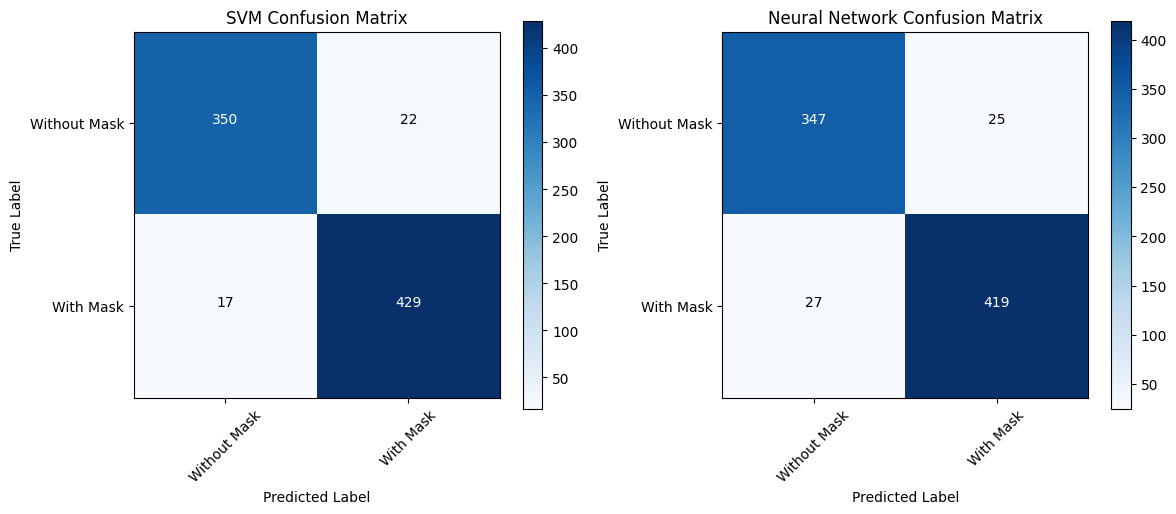

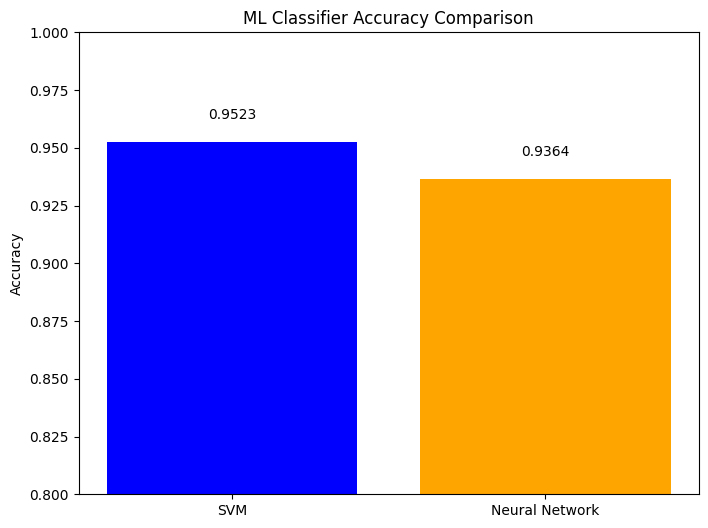


--- PART B: Binary Classification Using CNN ---

Loading images with masks for CNN...
Loading images without masks for CNN...
CNN Data prepared: 3268 training samples, 800 testing samples

Training CNN models with different hyperparameters...

Training configuration 1/6:
Learning Rate: 0.001, Optimizer: adam, Activation: relu, Batch Size: 16
Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.8161 - loss: 0.5480 - val_accuracy: 0.4538 - val_loss: 3.6431 - learning_rate: 0.0010
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.8594 - loss: 0.3954 - val_accuracy: 0.7300 - val_loss: 0.7181 - learning_rate: 0.0010
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.9009 - loss: 0.2729 - val_accuracy: 0.8763 - val_loss: 0.3155 - learning_rate: 0.0010
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.9092 - loss: 0.2364 - val_accuracy: 0.9400 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 5/15
205/205 ━━━━━━━━━━━━━━━━━━━

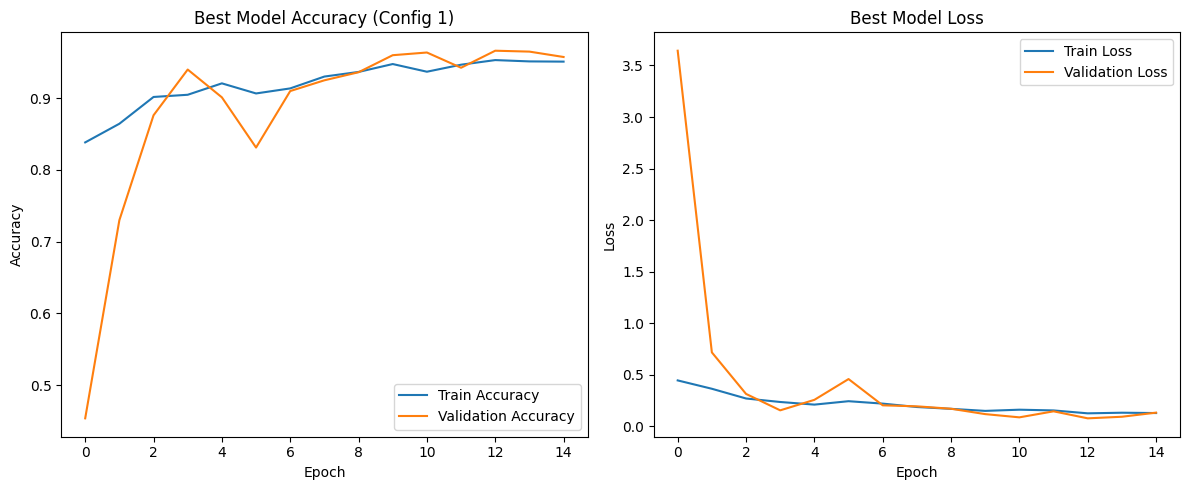


Visualizing CNN results...


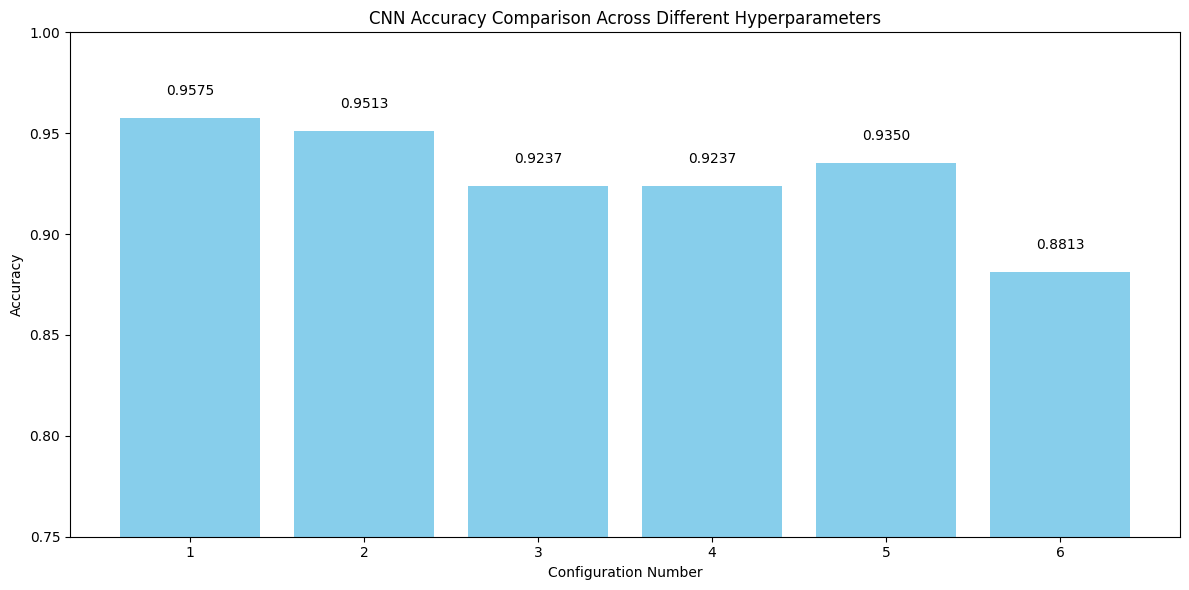

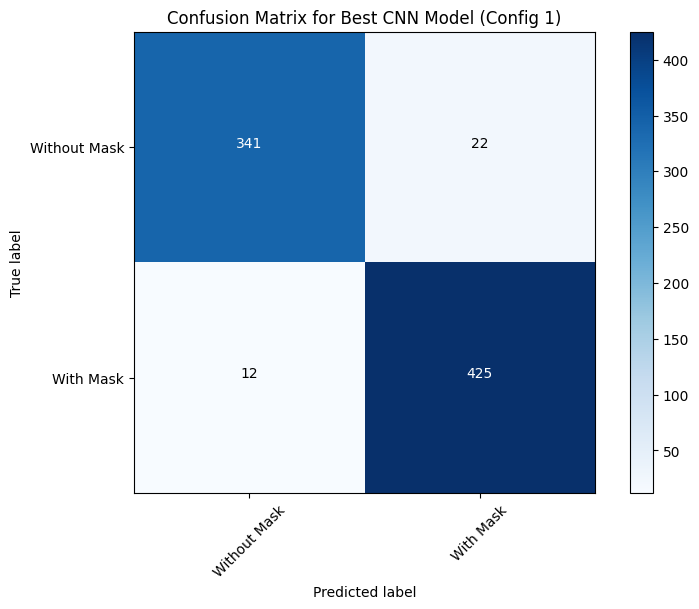


Best CNN Model Configuration:
Configuration 1:
Learning Rate: 0.001
Optimizer: adam
Activation: relu
Batch Size: 16
Accuracy: 0.9575

Classification Report for Best CNN Model:
              precision    recall  f1-score   support

Without Mask       0.97      0.94      0.95       363
   With Mask       0.95      0.97      0.96       437

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800


Comparing all methods (ML classifiers and CNN)...


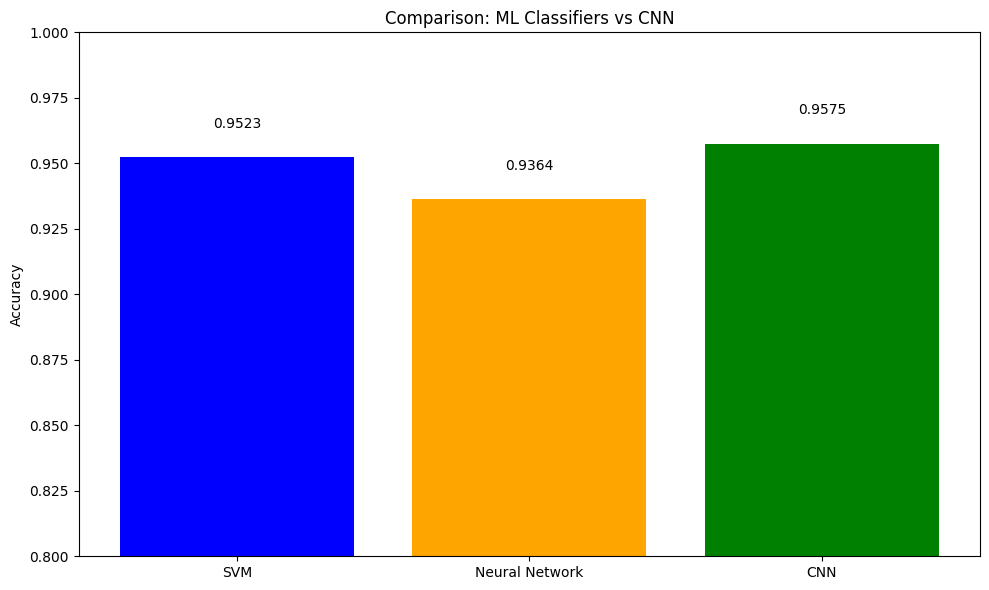


Comparison of All Methods:
SVM Accuracy: 0.9523
Neural Network Accuracy: 0.9364
CNN Accuracy: 0.9575

Best performing method: CNN

Analysis:
The CNN outperforms traditional ML classifiers, which is expected since CNNs can automatically learn relevant features from image data.

Best CNN model saved as 'best_cnn_model.h5'

Classification tasks completed successfully!


In [13]:
# Main function to run the entire pipeline
def main():
    # Define paths to your dataset
    with_mask_dir = '/kaggle/input/dataset/dataset/with_mask'
    without_mask_dir = '/kaggle/input/dataset/dataset/without_mask'
    
    # Part A: ML Classifiers with Handcrafted Features
    print("\n--- PART A: Binary Classification Using Handcrafted Features and ML Classifiers ---\n")
    
    # Load and preprocess data for ML classifiers
    X_train_ml, X_test_ml, y_train_ml, y_test_ml = prepare_data_ml(with_mask_dir, without_mask_dir)
    
    # Train and evaluate ML classifiers
    svm, mlp, svm_pred, mlp_pred, svm_accuracy, mlp_accuracy = train_evaluate_ml_classifiers(
        X_train_ml, X_test_ml, y_train_ml, y_test_ml
    )
    
    # Visualize ML results
    best_ml_accuracy = visualize_ml_results(y_test_ml, svm_pred, mlp_pred, svm_accuracy, mlp_accuracy)
    
    # Part B: CNN Classifier
    print("\n--- PART B: Binary Classification Using CNN ---\n")
    
    # Load and preprocess data for CNN
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, y_train_orig, y_test_orig = load_and_preprocess_data_cnn(
        with_mask_dir, without_mask_dir
    )
    
    # Train CNN with different hyperparameters
    print("\nTraining CNN models with different hyperparameters...")
    results, histories = train_with_hyperparameters(
        X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, y_train_orig, y_test_orig
    )
    
    # Visualize CNN training history
    print("\nVisualizing CNN training history...")
    best_idx = plot_training_history(histories, results)
    
    # Visualize CNN results
    print("\nVisualizing CNN results...")
    best_config = visualize_cnn_results(results, y_test_orig)
    
    # Compare all methods
    print("\nComparing all methods (ML classifiers and CNN)...")
    ml_accuracies = {
        'svm': svm_accuracy,
        'mlp': mlp_accuracy
    }
    
    compare_all_methods(best_config['accuracy'], ml_accuracies)
    
    # Save best CNN model
    best_model = results[best_idx]['model']
    best_model.save('best_cnn_model.h5')
    print("\nBest CNN model saved as 'best_cnn_model.h5'")
    
    print("\nClassification tasks completed successfully!")

# Run the main function
if __name__ == "__main__":
    main()